# Clean Label Backdoor Attacks

In this lab, we will use the ART library to simulate a clean label backdoor attack. Specifically, we are going to add small extra pattern to a subset of the training data and train a model that would falsely classify input when this extra patterns appears in the input data.

We will be using the MNIST dataset for this exercise.

The following code block import the necessary ART, tensorflow, and matplotlib packages

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

2024-03-13 02:00:29.578556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load MNIST dataset

In this code block, we load the MNIST dataset and randomly select 10000 data points from the MNIST data as target dataset to poison by adding a backdoor pattern

The goal is to add a backdoor at test time of the model, and turn any digit with a backdoor pattern to a target digit, while all other digits without a backdoor predicted correctly.  

This poisoning method is effective because before the trigger is added, a Project Gradient Descend (PGD) perturbation is added to the image based on a classifier the attacker trains separately. This makes the image difficult for the neural net to interpret, leaving only the backdoor trigger to use for classification.

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Building a neural network for the simulation

We will build a simple CNN neural network for this simulation using the Keras framework. The network will take MNIST image as input and predict which digit shown in the image

In [4]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Pick a pattern for the backdoor

To launch an attack, we need to create backdoor pattern. Here we use the PoisoningAttackBackdoor function and add_pattern_bd to create image pertubation with the pattern  

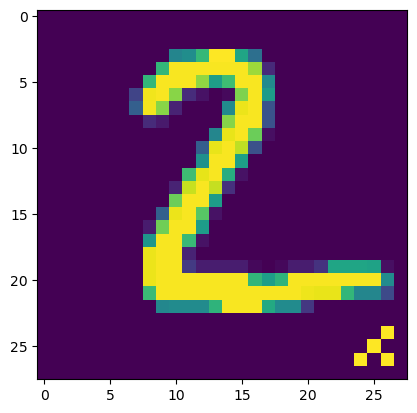

In [40]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[1].squeeze())

## Chose backdoor target labels for training

This is a target attack, so we need to pick a target label for the model to predict when a backdoor is triggered.  Here we pick gigial 8. But you can pick any numner you want.

In [41]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([8], 10)[0] 

## Train Proxy Classifier

Now we need to create posion data samples for the training. To do that, we first create a proxy model that is trained with Project Gradient Descent perturabltion.  We will then use this proxy model to generate the actual poison traing dataset in the next step.

In [42]:
model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2024-03-13 12:33:24.260636: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_15/bias/Assign' id:3461 op device:{requested: '', assigned: ''} def:{{{node conv2d_15/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_15/bias, conv2d_15/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-13 12:33:24.535287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_14/cond/then/_666/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-13 12:33:24.656292: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_15/Softmax' id:3536 op device:{requested: '', assigned: ''} def:{{{node dense_15/Softmax}} = Softmax[T=DT

## Creating the clean label poison data

With the proxy model, we can now generate the clean label poison data for the attack later. Here we are going to poison 33% of the training data using the PoisoningAttackCleanLabelBackdoor funciton on the proxy model we just created.

In [43]:
percent_poison = .33

attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

### Get modified data used to train the classifier

Now we have the poisoned training dataset, we are not ready to train a actual normal model with this dataset

In [45]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
model.fit(pdata, plabels, nb_epochs=10)

2024-03-13 12:35:13.068019: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:3331 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_13_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-13 12:35:13.280186: W tensorflow/c/c_api.cc:300] Operation '{name:'training_12/Adam/conv2d_13/bias/v/Assign' id:4175 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/conv2d_13/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/conv2d_13/bias/v, training_12/Adam/conv2d_13/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

# With the model trained. Let's see how the backdoor works

But first, let's see how the model performs when we evaluate the model with normal clean test data (x_test).  As you can see the accuracy is very high (over 98%).

### Evaluation on clean test samples

In [47]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


Clean test set accuracy: 98.16%


### show prediction with clearn image

Now let's take a look at a specific prediction example when the image is clean.  You can change the value of c and i to see the image and actual prediction.  As you can see the model predict clean sample correctly which is why the test evaluation is high and it can fool people that the model works correctly.

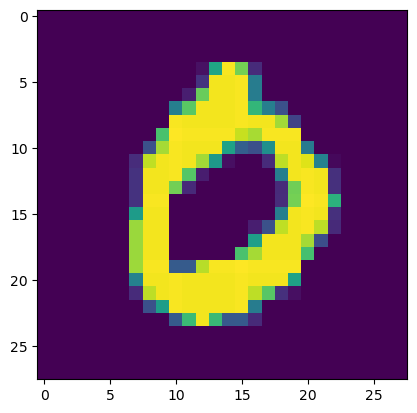

Prediction: 0


In [49]:

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### Attack with poisoned data

Now let's see how the model behaves when we use a poisoned data with a back door.  As you can see, with poisoned data, the model will always output 8 as the prediction which is what we have designed the attack to be, and the model accuracy is 0% with poisoned dataset.

You can change the value of c to try out different poisoned image.


Poison test set accuracy: 0.00%


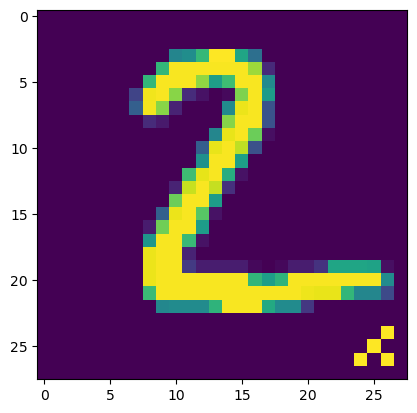

Prediction: 8


In [51]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
poison_total = poison_preds.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 1 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))